# Frontier Exploration

In [ ]:
import numpy as np
import typing as T
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

## Define the Stochastic Occupancy Grid Class

In [ ]:
def snap_to_grid(state: np.ndarray, resolution: float) -> np.ndarray:
    """ Snap continuous coordinates to a finite-resolution grid

    Args:
        state (np.ndarray): a size-2 numpy array specifying the (x, y) coordinates
        resolution (float): resolution of the grid

    Returns:
        np.ndarray: state-vector snapped onto the specified grid
    """
    return resolution * np.round(state / resolution)

class StochOccupancyGrid2D(object):
    """ A stochastic occupancy grid derived from ROS2 map data

    The probability of grid cell being occupied is computed by the joint probability of
    any neighboring cell being occupied within some fixed window. For some examples of size-3
    occupancy windows,

    0.1 0.1 0.1
    0.1 0.1 0.1  ->  1 - (1 - 0.1)**9 ~= 0.61
    0.1 0.1 0.1

    0.0 0.1 0.0
    0.0 0.1 0.0  ->  1 - (1 - 0)**6 * (1 - 0.1)**3 ~= 0.27
    0.0 0.1 0.0

    The final occupancy probability is then converted to binary occupancy using a threshold
    """

    def __init__(self,
        resolution: float,
        size_xy: np.ndarray,
        origin_xy: np.ndarray,
        window_size: int,
        probs: T.Sequence[float],
        thresh: float = 0.5
    ) -> None:
        """
        Args:
            resolution (float): resolution of the map
            size_xy (np.ndarray): size-2 integer array representing map size
            origin_xy (np.ndarray): size-2 float array representing map origin coordinates
            window_size (int): window size for computing occupancy probabilities
            probs (T.Sequence[float]): map data
            thresh (float): threshold for final binarization of occupancy probabilites
        """
        self.resolution = resolution
        self.size_xy = size_xy
        self.origin_xy = origin_xy
        self.probs = np.reshape(np.asarray(probs), (size_xy[1], size_xy[0]))
        self.window_size = window_size
        self.thresh = thresh

    def state2grid(self, state_xy: np.ndarray) -> np.ndarray:
        """ convert real state coordinates to integer grid indices

        Args:
            state_xy (np.ndarray): real state coordinates (x, y)

        Returns:
            np.ndarray: quantized 2D grid indices (kx, ky)
        """
        state_snapped_xy = snap_to_grid(state_xy, self.resolution)
        grid_xy = ((state_snapped_xy - self.origin_xy) / self.resolution).astype(int)

        return grid_xy

    def grid2state(self, grid_xy: np.ndarray) -> np.ndarray:
        """ convert integer grid indices to real state coordinates

        Args:
            grid_xy (np.ndarray): integer grid indices (kx, ky)

        Returns:
            np.ndarray: real state coordinates (x, y)
        """
        return (grid_xy * self.resolution + self.origin_xy).astype(float)

    def is_free(self, state_xy: np.ndarray) -> bool:
        """ Check whether a state is free or occupied

        Args:
            state_xy (np.ndarray): size-2 state vectory of (x, y) coordinate

        Returns:
            bool: True if free, False if occupied
        """
        # combine the probabilities of each cell by assuming independence of each estimation
        grid_xy = self.state2grid(state_xy)

        half_size = int(round((self.window_size-1)/2))
        grid_xy_lower = np.maximum(0, grid_xy - half_size)
        grid_xy_upper = np.minimum(self.size_xy, grid_xy + half_size + 1)

        prob_window = self.probs[grid_xy_lower[1]:grid_xy_upper[1],
                                 grid_xy_lower[0]:grid_xy_upper[0]]
        p_total = np.prod(1. - np.maximum(prob_window / 100., 0.))

        return (1. - p_total) < self.thresh

## Define the Ground Truth Map with Obstascles

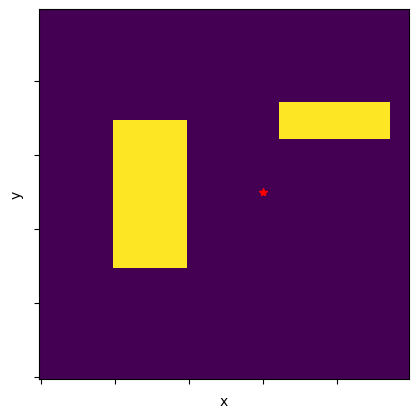

In [ ]:
current_state = np.array([6., 5.])
map_grid_size = np.array([100, 100])
resolution = 0.1

# Initialize ground truth occupancy grid
occupancy_gt = -np.ones((map_grid_size[1], map_grid_size[0]))
obstacles = [np.array([3, 5, 2, 4]), np.array([8, 7, 3, 1])] # x_center, y_center, width, height
obstacles_idxs =  [obstacle/resolution for obstacle in obstacles]
for obstacles_idx in obstacles_idxs:
    occupancy_gt[int(obstacles_idx[1]-obstacles_idx[3]/2.) : int(obstacles_idx[1]+obstacles_idx[3]/2.), int(obstacles_idx[0]-obstacles_idx[2]/2.) : int(obstacles_idx[0]+obstacles_idx[2]/2.)] = 1.0

# Plotting Functions
fig,ax = plt.subplots(1)
ax.imshow(occupancy_gt, origin='lower')
ax.plot(current_state[0]/resolution, current_state[1]/resolution, 'r*')
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

## Define the Stochastic Occupancy grid of obstacles detected by the robot

In [ ]:
# Initialize probabilistic occupancy grid
sensing_radius = 3.0
observed_bounds = [(current_state - sensing_radius)/resolution, (current_state + sensing_radius)/resolution]
occupancy_probs = -np.ones((map_grid_size[1], map_grid_size[0]))

for x_idx in range(int(observed_bounds[0][0]), int(observed_bounds[1][0]), 1):
    for y_idx in range(int(observed_bounds[0][1]), int(observed_bounds[1][1]), 1):
        if np.linalg.norm(np.array([x_idx*resolution, y_idx*resolution]) - current_state) < sensing_radius:
            if occupancy_gt[y_idx, x_idx] < 0.0:
                occupancy_probs[y_idx, x_idx] = 0.0
            else:
                occupancy_probs[y_idx, x_idx] = 0.8

In [ ]:
# Create Stochastic Occupancy grid
occupancy = StochOccupancyGrid2D(resolution=resolution,
        size_xy=map_grid_size,
        origin_xy=np.zeros((2,)),
        window_size=7,
        probs=occupancy_probs,
        thresh=0.5)

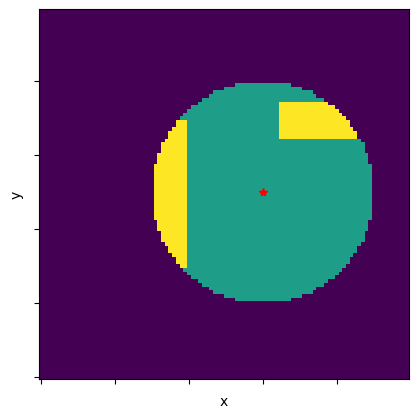

In [ ]:
# Plot Stochastic Occupancy grid
fig,ax = plt.subplots(1)
ax.imshow(occupancy.probs, origin='lower')
ax.plot(current_state[0]/resolution, current_state[1]/resolution, 'r*')
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

## Frontier Exploration within robot's Stochastic Occupancy map

2.596150997149434


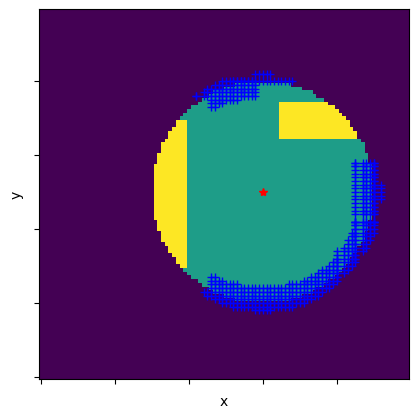

In [ ]:
def explore(occupancy):
    """ returns potential states to explore
    Args:
        occupancy (StochasticOccupancyGrid2D): Represents the known, unknown, occupied, and unoccupied states. See class in first section of notebook.

    Returns:
        frontier_states (np.ndarray): state-vectors in (x, y) coordinates of potential states to explore. Shape is (N, 2), where N is the number of possible states to explore.

    HINTS:
    - Function `convolve2d` may be helpful in producing the number of unknown, and number of occupied states in a window of a specified cell
    - Note the distinction between physical states and grid cells. Most operations can be done on grid cells, and converted to physical states at the end of the function with `occupancy.grid2state()`
    """

    window_size = 13    # defines the window side-length for neighborhood of cells to consider for heuristics
    ########################### Code starts here ###########################

    probs = occupancy.probs.copy()
    probs_unknown = occupancy.probs.copy()
    probs_occupied = occupancy.probs.copy()
    probs_free = occupancy.probs.copy()

    unknown_ker = np.ones((window_size, window_size))
    surroundings = convolve2d(np.ones_like(probs), unknown_ker, mode='same', boundary='fill', fillvalue=0)
    # print("surroundings = ", surroundings[50,:])

    # print("probs = ", probs_unknown[50, :])
    probs_unknown[probs_unknown == 0.8] = 0.0
    probs_unknown[probs_unknown == -1] = 1
    # print("probs = ", probs_unknown[50,:])
    unknown_output = convolve2d(probs_unknown, unknown_ker, mode='same', boundary='fill', fillvalue=0)
    # print("unknown output = ", unknown_output[50,:])
    unknown_output = np.divide(unknown_output, surroundings)
    # print("unknown output = ", unknown_output[50,:])
    unknown_output[unknown_output > 0.2] = 1
    unknown_output[unknown_output != 1] = 0.0
    # print("unknown output = ", unknown_output[50, :])


    probs_occupied[probs_occupied == -1] = 0.0
    probs_occupied[probs_occupied == 0.8] = 1

    # print("probs_occupied = ", probs_occupied[50,:])
    occupied_output = convolve2d(probs_occupied, unknown_ker, mode='same', boundary='fill', fillvalue=0)
    occupied_output[occupied_output != 0] = -1
    occupied_output[occupied_output == 0] = 1
    occupied_output[occupied_output == -1] = 0
    # print(occupied_output[50, :])

    probs_free[probs_free == 0] = 1
    probs_free[probs_free != 1] = 0
    free_output = convolve2d(probs_free, unknown_ker, mode='same', boundary='fill', fillvalue=0)
    free_output = np.divide(free_output, surroundings)
    # print("free output = ", np.sum(free_output))
    free_output[free_output >= 0.3] = 1
    free_output[free_output != 1] = 0

    final_output = unknown_output + occupied_output + free_output
    # print(final_output[50,:])
    # print(unknown_output[50,:])
    # print(occupied_output[50,:])
    # print(free_output[50,:])

    final_output[final_output != 3] = 0
    final_output = final_output.T/3

    frontier_states = occupancy.grid2state(np.column_stack(np.where(final_output == 1)))
    # print(frontier_states)

    distances = np.sqrt(np.sum((frontier_states - current_state)**2, axis=1))
    print(np.min(distances))

    ########################### Code ends here ###########################
    return frontier_states

# Call to explore function
state_xy = explore(occupancy)
grid_xy = occupancy.state2grid(state_xy)

# Plot Stochastic Occupancy grid with frontier to explore
fig,ax = plt.subplots(1)
ax.imshow(occupancy.probs, origin='lower')
ax.plot(current_state[0]/resolution, current_state[1]/resolution, 'r*')
ax.plot(grid_xy[:,0], grid_xy[:,1], 'b+')
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()